<a href="https://colab.research.google.com/github/cuboid0223/Deep-Generative-Models/blob/main/Grad_Cam_Cat%26Dog_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip /content/gdrive/MyDrive/raw-img.zip

In [2]:
import os
# list_animals_names = ['dog', 'horse', 'elephant', 'buterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
list_animals_names = ['dog', 'cat']
list_ori_folder = os.listdir('/content/raw-img')
# Make directory structure
path = "/content/animal-10"
os.mkdir(path)

def make_directory(name_catalogy):
  sub_path = path + '/' + name_catalogy
  os.mkdir(sub_path)
  for animal_name in list_animals_names:
    os.mkdir(sub_path + '/' + animal_name)
  return

make_directory("train")
make_directory("validation")
make_directory("test")

In [3]:
# for OSX use
# ! sudo find . -name ".DS_Store" -depth -exec rm {} \;


find: warning: you have specified the global option -depth after the argument -name, but global options are not positional, i.e., -depth affects tests specified before it as well as those specified after it.  Please specify global options before other arguments.


In [4]:
import shutil
import os
# ratio for train, val, and test set
ratio_train = 0.7
ratio_val = 0.15
ratio_test = ratio_train - ratio_val

ori_raw_folder = "/content/raw-img"
# list_animals_names = ['dog', 'horse', 'elephant', 'buterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
list_animals_names = ['dog', 'cat']
list_ori_folder = sorted(os.listdir('/content/raw-img'))
print(list_ori_folder)
for sub_ori_folder, sub_new_folder in zip(list_ori_folder, list_animals_names): # get a folder name
  sub_raw_img_name = ori_raw_folder + '/' + sub_ori_folder # address in "raw-img" folder
  list_img_in_raw_img = os.listdir(sub_raw_img_name) # List image in sub "raw_img" folder


  for i, img_org_name in enumerate(list_img_in_raw_img):
    if i / len(list_img_in_raw_img) < ratio_train:        # Copy train
      shutil.copy(sub_raw_img_name + '/' + img_org_name,
                  path + '/train/' + sub_new_folder + '/'
                  + sub_new_folder + '.' + str(i) + '.jpeg' )
    elif (i / len(list_img_in_raw_img) > ratio_train) and (i / len(list_img_in_raw_img) < ratio_train + ratio_val): # Copy val
      shutil.copy(sub_raw_img_name + '/' + img_org_name,
                  path + '/validation/' + sub_new_folder + '/'
                  + sub_new_folder + '.' + str(i) + '.jpeg' )
    else: # Copy test
      shutil.copy(sub_raw_img_name + '/' + img_org_name,
                  path + '/test/' + sub_new_folder + '/'
                  + sub_new_folder + '.' + str(i) + '.jpeg' )


['cane', 'gatto']


In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
img_size = (180, 180)

train_dataset = image_dataset_from_directory(
 path + "/train",
 image_size=img_size,
 batch_size=32)
validation_dataset = image_dataset_from_directory(
 path + "/validation",
 image_size=img_size,
 batch_size=32)
test_dataset = image_dataset_from_directory(
 path + "/test",
 image_size=img_size,
 batch_size=32)

Found 4573 files belonging to 2 classes.
Found 979 files belonging to 2 classes.
Found 979 files belonging to 2 classes.


In [6]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [7]:
conv_base.trainable = False
"""for layer in conv_base.layers[:-2]:
  layer.trainable = False"""

data_augmentation = keras.Sequential(
    [
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.1)
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
#x = data_augmentation(inputs)
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="classify_animals_10.x",
        save_best_only=True,
        monitor="val_loss"
    )
]


In [8]:
conv_base.summary()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [9]:

history = model.fit(
 train_dataset,
 epochs=10,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/10
143/143 [==============================] - 36s 168ms/step - loss: 1.9392 - accuracy: 0.8264 - val_loss: 0.6744 - val_accuracy: 0.9019
Epoch 2/10
143/143 [==============================] - 19s 129ms/step - loss: 0.4036 - accuracy: 0.9296 - val_loss: 0.4499 - val_accuracy: 0.9203
Epoch 3/10
143/143 [==============================] - 19s 129ms/step - loss: 0.2866 - accuracy: 0.9471 - val_loss: 0.3706 - val_accuracy: 0.9305
Epoch 4/10
143/143 [==============================] - 21s 142ms/step - loss: 0.2170 - accuracy: 0.9536 - val_loss: 0.3259 - val_accuracy: 0.9305
Epoch 5/10
143/143 [==============================] - 19s 129ms/step - loss: 0.1858 - accuracy: 0.9563 - val_loss: 0.2991 - val_accuracy: 0.9418
Epoch 6/10
143/143 [==============================] - 20s 139ms/step - loss: 0.1628 - accuracy: 0.9595 - val_loss: 0.2893 - val_accuracy: 0.9499
Epoch 7/10
143/143 [==============================] - 19s 129ms/step - loss: 0.1412 - accuracy: 0.9622 - val_loss: 0.2762 - val_ac

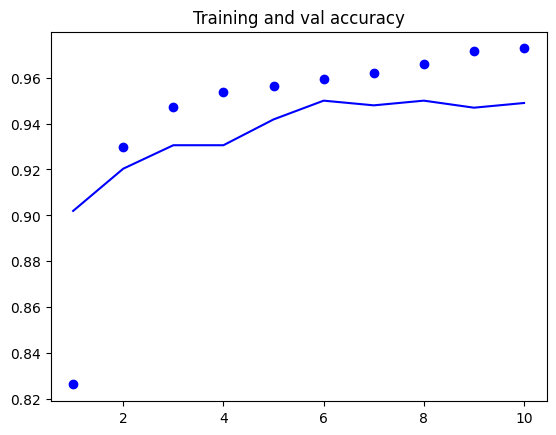

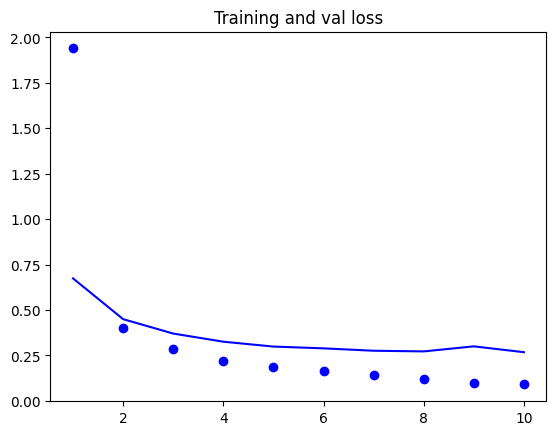

In [10]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Val_accuracy")
plt.title("Training and val accuracy")
plt.show()
plt.figure()
plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Training and val loss")
plt.show()

In [11]:
# Evaluating the model on the test set
test_model = keras.models.load_model("classify_animals_10.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print("Test accurary: %.4f" %test_acc)

31/31 [==============================] - 3s 92ms/step - loss: 0.2628 - accuracy: 0.9510
Test accurary: 0.9510


In [16]:

#Setting up a model return the last convolutinal output
last_conv_layer_name = "block5_conv3"
classifier_layer_names = ["global_average_pooling2d","dense"]
last_conv_layer = conv_base.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(conv_base.inputs, last_conv_layer.output)

In [17]:
# Reapplying the classifier on top of the last convolutional output
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
  x = test_model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [18]:
# Retrieving the gradients of the top predicted class
import tensorflow as tf

def get_grads(img_array):
  with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array) #TensorShape([1, 11, 11, 512])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)  #TensorShape([1, 10])
    top_pred_index = tf.argmax(preds[-1])  #TensorShape([10])
    top_class_channel = preds[:, top_pred_index]
  grads = tape.gradient(top_class_channel, last_conv_layer_output)
  return grads, last_conv_layer_output

In [28]:
import matplotlib.cm as cm
import tensorflow as tf
import numpy as np

list_online_image =[
    "https://i.imgur.com/rQqOBeQ.png",
    "https://www.dogsnsw.org.au/media/1007/breeding-dogs.jpg",
    "https://p3-tt.byteimg.com/origin/pgc-image/768380d0c8c64873a1264091fb6271a9?from=pc",
    "https://pgw.udn.com.tw/gw/photo.php?u=https://uc.udn.com.tw/photo/2022/03/14/0/16270800.jpg&x=0&y=0&sw=0&sh=0&sl=W&fw=800&exp=3600&w=930",
    "https://img.ltn.com.tw/Upload/news/600/2022/07/15/phpObQb9k.jpg",
    "https://i.imgur.com/Et1eIIO.jpeg",
    "https://pic2.zhimg.com/80/v2-42c1d1da3ada948c2c4ecbe1c79b6f81_1440w.webp",
    "https://memeprod.sgp1.digitaloceanspaces.com/user-wtf/1610791594435.jpg",
    "https://image.cache.storm.mg/styles/smg-800x533-fp/s3/media/image/2019/07/31/20190731-070006_U11552_M540181_2dd4.jpg?itok=LSvUwU_x"
]
heatmaps = np.zeros((9, 11, 11))
img_arrays = np.zeros((9, 180, 180, 3))

#Convert link image to array
def get_img_array(img_path, target_size):
  img_path = keras.utils.get_file(origin = img_path)
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = keras.applications.xception.preprocess_input(array)
  return array


for k, link in enumerate(list_online_image):
  img_array = get_img_array(link, target_size=(180, 180))
  img_arrays[k, :, :, :] = img_array
  grad, last_conv_layer_output = get_grads(img_array) #get grads funtion

  pooled_grads = tf.reduce_mean(grad, axis=(0, 1, 2)).numpy()
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmaps[k, :, :] = heatmap

1321513/1321513 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 22ms/step
[0 1 0 1 0 0 0 0 0]


<ipython-input-29-812acfdcd730>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


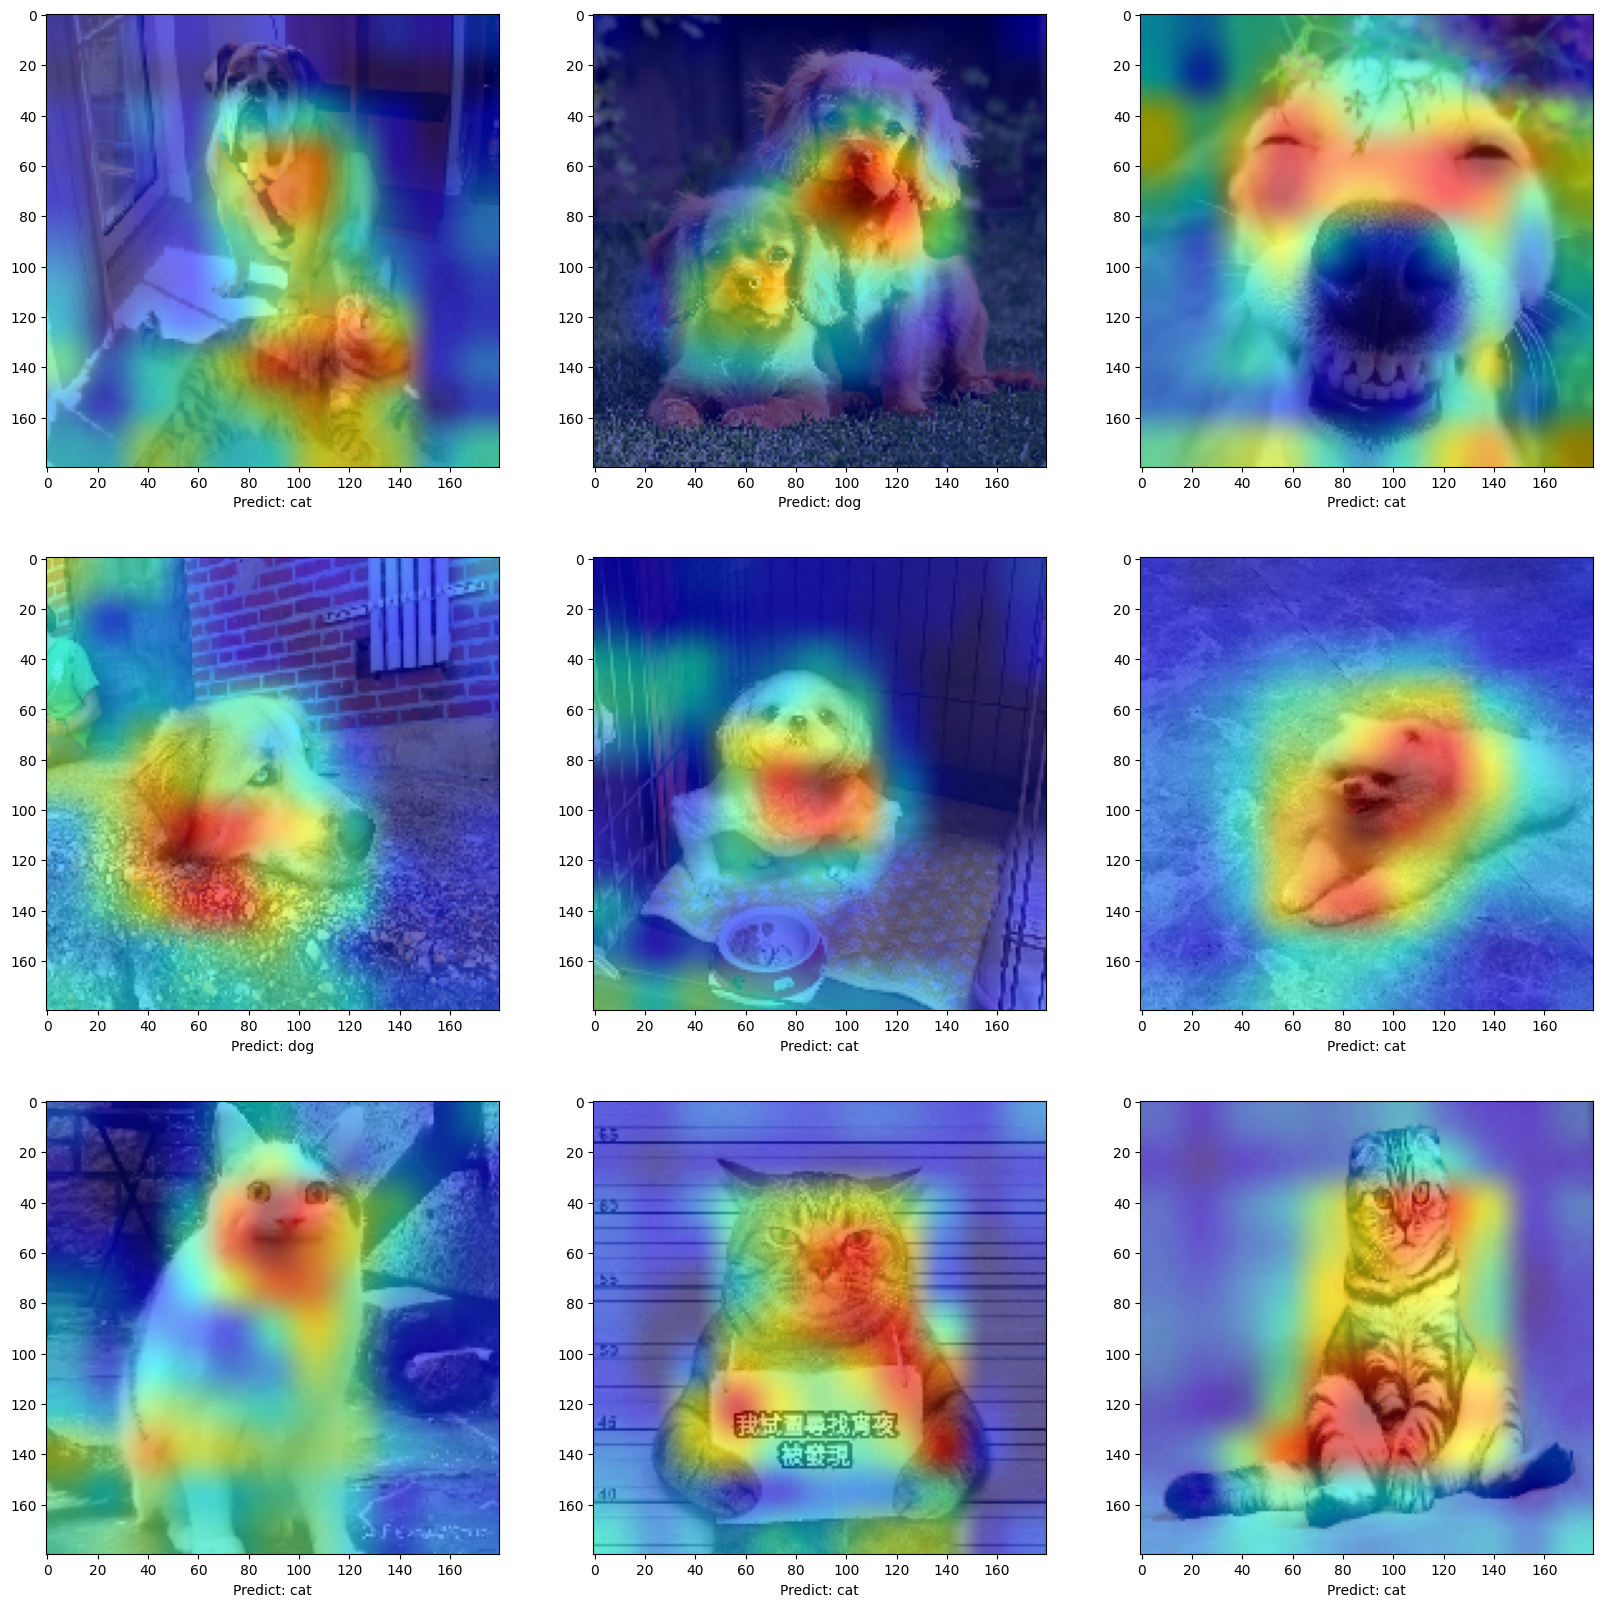

In [29]:
# Plot the result.
import matplotlib.cm as cm
import matplotlib.pyplot as plt

catalogi = sorted(os.listdir('/content/animal-10/train'))
predict_value = test_model.predict(img_arrays)
predict_value = np.argmax(predict_value, axis = -1)
print(predict_value)

plt.figure(figsize=(20,20))
for i in range(9):

  plt.subplot(330 + 1 + i)
  img = img_arrays[i]
  heatmap = np.uint8(255 * heatmaps[i])
  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * 0.01 + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  predict_index = predict_value[i]
  name_of_predict = catalogi[predict_index]
  plt.xlabel("Predict: %s" %name_of_predict)
  plt.imshow(superimposed_img)
plt.show()
